# Optimizers
|  | Monday 4-5:30pm | Friday  4-5:30pm |
|:------:|:-------------------------------------------:|:--------------------------------------------------------------------------:|
| **Week 1** | Introduction | Introduction |
| **Week 2** | Custom computer vision tasks | State of the art in Computer Vision |
| **Week 3** | Introduction to Tabular modeling and pandas | Pandas workshop and feature engineering |
| **Week 4** | Tabular and Image Regression | Feature importance and advanced feature  engineering |
| **Week 5** | Natural Language Processing | State of the art in NLP |
| **Week 6** | Segmentation and Kaggle | Audio |
| **Week 7** | Computer vision from scratch | NLP from scratch |
| **Week 8** | Callbacks | **Optimizers** |
| **Week 9** | Generative Adversarial Networks | Research time / presentations |
| **Week 10** | Putting models into production | Putting models into production |

<h1> What is <b>Gradient Decent</b>?</h1>

<h2>
  
  "Gradient descent is an optimization algorithm used to minimize some function by iteratively moving in the direction of steepest descent as defined by the negative of the gradient. In machine learning, we use gradient descent to update the parameters of our model. Parameters refer to coefficients in Linear Regression and weights in neural networks."
  </h2>
  
  
  https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html

![alt text](https://cdn-images-1.medium.com/max/1600/1*WGHn1L4NveQ85nn3o7Dd2g.png)

![alt text](https://camo.githubusercontent.com/203d02ce525466161d67c695e7912a364e16a015/68747470733a2f2f692e737461636b2e696d6775722e636f6d2f316f6274562e676966)

![alt text](https://blog.algorithmia.com/wp-content/uploads/2018/05/word-image-2-1024x479.png)

<h2>Stochastic Gradient Decent (SGD)</h2>

Instead of calculating the gradient (loss) for *all* training examples, do it on a subset

<h2>Adagrad</h2>

Dispenses weights to different individual features in the dataset. Issues: learning rate gets *really* small over time

<h2> RMSprop</h2>
Special version of Adagrad. Instead of letting all gradients accumulate for momentum, only does so in a fixed window

<h2>Adam</h2>
ADAM: Adaptive Moment Estimation, uses past gradients to calculate current gradients. Also utilizes the concept of momentum by adding fractions of previous gradients.

<h2>AdamW</h2>

![alt text](https://www.fast.ai/images/adamw_charts.png)

## Properly tuned, Adam really works! We got new state of the art results (in terms of training time) on various tasks like


### *   training CIFAR10 to >94% accuracy in as few as 18 epochs with Test Time Augmentation or with 30 epochs without, as in the DAWNBench competition;
### *   fine-tuning Resnet50 to 90% accuracy on the Cars Stanford Dataset in just 60 epochs (previous reports to the same accuracy used 600);
### * training from scratch an AWD LSTM or QRNN in 90 epochs (or 1 hour and a half on a single GPU) to state-of-the-art perplexity on Wikitext-2 (previous reports used 750 for LSTMs, 500 for QRNNs).

## That means that we’ve seen (for the first time we’re aware of) super convergence using Adam! Super convergence is a phenomenon that occurs when training a neural net with high learning rates, growing for half the training. Before it was understood, training CIFAR10 to 94% accuracy took about 100 epochs.

## In contrast to previous work, we see Adam getting about as good accuracy as SGD+Momentum on every CNN image problem we’ve tried it on, as long as it’s properly tuned, and it’s nearly always a bit faster too.

## The suggestions that amsgrad are a poor “fix” are correct. We consistently found that amsgrad didn’t achieve any gain in accuracy (or other relevant metric) than plain Adam/AdamW.

All have the same goal: Minimize the Loss Function

In [0]:
from fastai import *
from fastai.vision import *

Today we will look at those optimizers above, also a few state of the art optimizers, and see how they do on the ImageWoof dataset.

What is ImageWoof? 
* Imagenet but for dogs
* Harder
* [Competition by Jeremy](https://github.com/fastai/imagenette)
* Fast dataset to train with

# Data

Since the data will not change, we will use 256x256 for 5 epochs, with a learning rate of 1e-2

In [0]:
path = untar_data(URLs.IMAGEWOOF_320)

In [0]:
data = (ImageList.from_folder(path)
       .split_by_folder(valid='val')
       .label_from_folder()
       .transform(([flip_lr(p=0.5)], []), size=256)
       .databunch()
       .presize(256, scale=(0.35,1))
       .normalize(imagenet_stats))

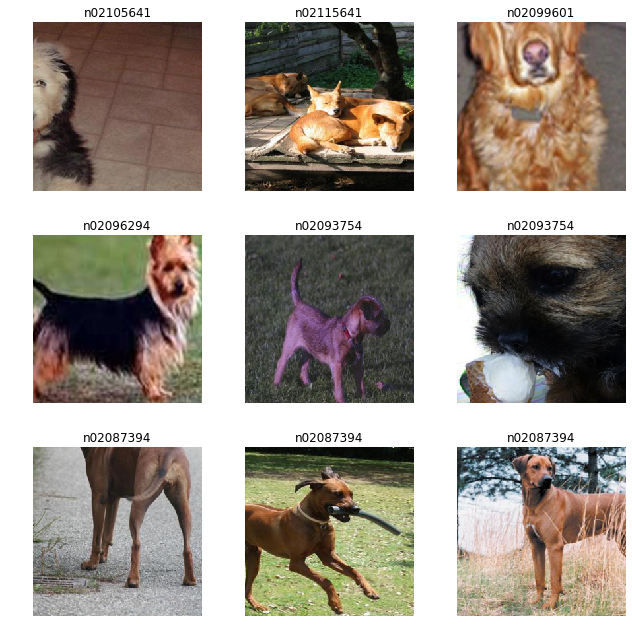

In [6]:
data.show_batch(rows=3, figsize=(9,9))

# Optimizers:

Today we will use the following optimizers:

* SGD (Stochastic gradient descent)
* Adam
* AdamW
* RAdam + LookAhead (Ranger) [RAdam](https://arxiv.org/abs/1908.03265) [LookAhead](http://arxiv.org/abs/1907.08610)
* Novograd [paper](https://arxiv.org/abs/1905.11286)

As the fastai library is module based, our optimizers go into `opt_func`, where we pass in a `partial()` of the one we want. For the sake of experimentation, today we will train using the resnet34 architecture, *not* pretrained.

Now one thing to note, most of the *new* learning rates do better roughly 8x higher than Adam and SGD, so we will do that here. 

SGD, Adam, and AdamW will get 3e-3, and everything else wil get 5e-2

# SGD

In [0]:
sgd = cnn_learner(data, models.resnet34, pretrained=False, metrics=[accuracy, top_k_accuracy], 
                 opt_func=partial(optim.SGD)).to_fp16()

sgd.unfreeze()

In [16]:
sgd.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.472395,2.184359,0.172000,0.660000,01:08
1,2.208960,2.002058,0.252000,0.776000,01:07
2,2.095529,1.931166,0.284000,0.810000,01:08
3,1.991176,1.861361,0.326000,0.814000,01:08
4,1.939602,1.829703,0.310000,0.844000,01:07


Our baseline is ~31% overall with ~84.4%, let's see how the rest stack up

# Adam (fastai default)

In [0]:
adam = cnn_learner(data, models.resnet34, pretrained=False, metrics=[accuracy, top_k_accuracy], 
                 opt_func=partial(optim.Adam)).to_fp16()

adam.unfreeze()

In [18]:
adam.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.328464,2.249648,0.212000,0.714000,01:09
1,2.037509,1.917086,0.310000,0.788000,01:09
2,1.783798,1.892927,0.322000,0.840000,01:09
3,1.551739,1.559259,0.438000,0.900000,01:08
4,1.398000,1.278137,0.548000,0.938000,01:08


Already we can see the improvement within the first epoch! - SOTA on the leaderboard is 67.6%, and there was a much larger improvement!

# AdamW

Now we are escaping the fastai library and bringing in other pytorch optimizers (fun fact we have been all along, compare `torch.optim` and our `optim`)

## Code

[Source](https://gist.github.com/colllin/0b146b154c4351f9a40f741a28bff1e3)

In [0]:
import torch
import math

class AdamW(torch.optim.Optimizer):
    """Implements AdamW algorithm.
    It has been proposed in `Fixing Weight Decay Regularization in Adam`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
    .. Fixing Weight Decay Regularization in Adam:
    https://arxiv.org/abs/1711.05101
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay)
        super(AdamW, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('AdamW does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # according to the paper, this penalty should come after the bias correction
                # if group['weight_decay'] != 0:
                #     grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # w = w - wd * lr * w
                if group['weight_decay'] != 0:
                    p.data.add_(-group['weight_decay'] * group['lr'], p.data)
                
                # w = w - lr * w.grad
                p.data.addcdiv_(-step_size, exp_avg, denom)

                # w = w - wd * lr * w - lr * w.grad
                # See http://www.fast.ai/2018/07/02/adam-weight-decay/

        return loss

## Training

In [0]:
adamw = cnn_learner(data, models.resnet34, pretrained=False, metrics=[accuracy, top_k_accuracy], 
                 opt_func=partial(AdamW)).to_fp16()

adamw.unfreeze()

In [21]:
adam.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.806981,3.514775,0.206000,0.666000,01:08
1,1.764289,2.121217,0.304000,0.768000,01:08
2,1.545158,1.400504,0.482000,0.920000,01:08
3,1.331550,1.229609,0.544000,0.958000,01:08
4,1.160304,1.029992,0.634000,0.968000,01:08


We're getting closer to that best!

# Ranger

From here we will be using 5e-2 as our learning rate. We may not get the most ideal results, keep playing with this. Ranger is quite a special optimizer, and Jeremy was impressed by it.

Article by the author, LessW2020 (figured out to combine them) [Medium](https://medium.com/@lessw/new-state-of-the-art-ai-optimizer-rectified-adam-radam-5d854730807b?source=friends_link&sk=9c4afcd7d9a77f75c002b650be01db0a)

In [28]:
!git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer.git
%cd Ranger-Deep-Learning-Optimizer

from ranger import Ranger

/content/Ranger-Deep-Learning-Optimizer


In [0]:
ranger = cnn_learner(data, models.resnet34, pretrained=False, metrics=[accuracy, top_k_accuracy], 
                 opt_func=partial(Ranger)).to_fp16()

ranger.unfreeze()

In [30]:
ranger.fit_one_cycle(5, 5e-2)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.319147,11.467492,0.124000,0.596000,01:08
1,2.164948,2.792729,0.186000,0.716000,01:08
2,1.951501,1.766300,0.348000,0.876000,01:09
3,1.684609,1.623841,0.392000,0.878000,01:08
4,1.489376,1.437741,0.480000,0.920000,01:08


# Novograd

* Based on Jeremy's interest, keep an eye on things he has ideas about

## Code

[Source](https://github.com/NVIDIA/DeepLearningExamples/blob/master/PyTorch/SpeechRecognition/Jasper/optimizers.py)

In [0]:
from torch.optim import Optimizer

In [0]:
class Novograd(Optimizer):
    """
    Implements Novograd algorithm.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.95, 0))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        grad_averaging: gradient averaging
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    """

    def __init__(self, params, lr=1e-3, betas=(0.95, 0), eps=1e-8,
                 weight_decay=0, grad_averaging=False, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                      weight_decay=weight_decay,
                      grad_averaging=grad_averaging,
                      amsgrad=amsgrad)

        super(Novograd, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Novograd, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
            and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Sparse gradients are not supported.')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros([]).to(state['exp_avg'].device)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros([]).to(state['exp_avg'].device)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                norm = torch.sum(torch.pow(grad, 2))

                if exp_avg_sq == 0:
                    exp_avg_sq.copy_(norm)
                else:
                    exp_avg_sq.mul_(beta2).add_(1 - beta2, norm)

                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                grad.div_(denom)
                if group['weight_decay'] != 0:
                    grad.add_(group['weight_decay'], p.data)
                if group['grad_averaging']:
                    grad.mul_(1 - beta1)
                exp_avg.mul_(beta1).add_(grad)

                p.data.add_(-group['lr'], exp_avg)
        
        return loss

## Training

In [0]:
novograd = cnn_learner(data, models.resnet34, pretrained=False, metrics=[accuracy, top_k_accuracy], 
                 opt_func=partial(Novograd)).to_fp16()

novograd.unfreeze()

In [41]:
novograd.fit_one_cycle(5, 5e-2)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.323628,14.350164,0.106000,0.568000,01:09
1,2.120546,2.224551,0.190000,0.706000,01:08
2,1.923888,1.944621,0.290000,0.804000,01:09
3,1.780337,1.751592,0.364000,0.860000,01:08
4,1.597526,1.532807,0.474000,0.896000,01:08


# What can you do?

Try implementing them for longer! The Imagenette and Imagewoof leaderboards have three image sizes for four epoch ranges. See how those new state-of-the-art optimizers do!